In [1]:
import numpy as np
import random
import os
import shutil

# ! pip install split-folders
import splitfolders

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

import matplotlib.pyplot as plt

rs = 42
def reset_random_seeds(rs):
   os.environ['PYTHONHASHSEED']=str(rs)
   tf.random.set_seed(rs)
   np.random.seed(rs)
   random.seed(rs)
reset_random_seeds(rs)

map_dir = 'map 4'

remove prev saved database:

In [2]:
dir_path = './data/humanModel_dataset_split'
if os.path.exists(dir_path):
    shutil.rmtree(dir_path)
else:
    print("File not found in the directory")

# Part 1 - Data Preprocessing

## Split into train , test data

In [3]:
# train, test split
splitfolders.ratio('./data/humanModel_dataset/', output="./data/humanModel_dataset_split", ratio=(0.8, 0.2))

Copying files: 5175 files [00:00, 16989.03 files/s]


### Preprocessing the Training set

In [4]:
batch_size = 64
IMG_SIZE = 10

datagen = ImageDataGenerator(rescale = 1./255)
train = datagen.flow_from_directory('./data/humanModel_dataset_split/train',
                                          target_size = (IMG_SIZE,IMG_SIZE), batch_size = batch_size, seed=rs, class_mode='sparse')

test = datagen.flow_from_directory('./data/humanModel_dataset_split/val',
                                            target_size = (IMG_SIZE, IMG_SIZE), batch_size = batch_size, seed=rs, class_mode='sparse')

Found 4138 images belonging to 5 classes.
Found 1037 images belonging to 5 classes.


## View some data

In [5]:
num_classes = 5

model = Sequential([
  layers.Conv2D(8, 4, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=[IMG_SIZE,IMG_SIZE,3]),
  layers.Conv2D(16, 4, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
  layers.Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
  layers.MaxPooling2D(),
  layers.Conv2D(8, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
  layers.Dense(num_classes, activation='softmax')
])

2021-12-29 13:40:38.503638: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-29 13:40:38.508103: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-29 13:40:38.508425: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-29 13:40:38.509082: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [6]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 10, 10, 8)         392       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2064      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 5, 8)           1160      
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 200)               0

In [8]:
epochs=200
history = model.fit(
  train,
  validation_data=test,
  epochs=epochs
)

2021-12-29 13:40:39.191195: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
/home/ido/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


Epoch 1/200


2021-12-29 13:40:39.822656: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8300


65/65 [==============================] - 2s 13ms/step - loss: 1.5282 - accuracy: 0.3760 - val_loss: 1.4042 - val_accuracy: 0.4995
Epoch 2/200
65/65 [==============================] - 1s 10ms/step - loss: 1.3279 - accuracy: 0.5097 - val_loss: 1.1761 - val_accuracy: 0.5718
Epoch 3/200
65/65 [==============================] - 1s 10ms/step - loss: 1.1929 - accuracy: 0.5607 - val_loss: 1.1023 - val_accuracy: 0.6143
Epoch 4/200
65/65 [==============================] - 1s 10ms/step - loss: 1.1129 - accuracy: 0.5996 - val_loss: 1.0562 - val_accuracy: 0.6239
Epoch 5/200
65/65 [==============================] - 1s 10ms/step - loss: 1.0612 - accuracy: 0.6194 - val_loss: 1.0086 - val_accuracy: 0.6374
Epoch 6/200
65/65 [==============================] - 1s 11ms/step - loss: 1.0112 - accuracy: 0.6329 - val_loss: 0.9689 - val_accuracy: 0.6500
Epoch 7/200
65/65 [==============================] - 1s 10ms/step - loss: 0.9796 - accuracy: 0.6515 - val_loss: 0.9325 - val_accuracy: 0.6586
Epoch 8/200
65/65 

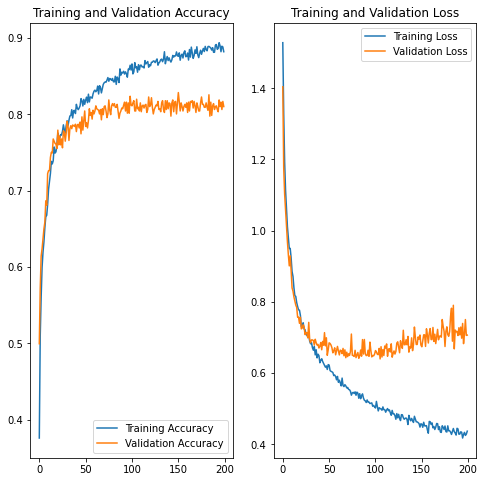

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [10]:
loss, accuracy = model.evaluate(test)
print('Test accuracy :', accuracy)

17/17 [==============================] - 0s 7ms/step - loss: 0.7066 - accuracy: 0.8100
Test accuracy : 0.8100289106369019


In [11]:
# Save the entire model as a SavedModel.
# model.save('./data/humanModel/mode_v0')
model.save('./data/'+map_dir+'/humanModel_v0.h5')

In [12]:
# save model in js format
# import tensorflowjs as tfjs
# tfjs.converters.save_keras_model(model, 'data/humanModel/js_model_v0')

In [13]:
# new_model = tf.keras.models.load_model('./data/humanModel/mode_v0')

# # Check its architecture
# new_model.summary()

### Predict on new data

In [14]:
path = "./data/humanModel_dataset_split/val/38/-Mr4e3Fomo72jz0zfTgB_14.png"

img = keras.preprocessing.image.load_img(
    path, target_size=(IMG_SIZE, IMG_SIZE)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)[0]

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(np.argmax(predictions), 100 * np.max(predictions))
)

FileNotFoundError: [Errno 2] No such file or directory: './data/humanModel_dataset_split/val/38/-Mr4e3Fomo72jz0zfTgB_14.png'